## Dependencias

In [122]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import re
import unicodedata

import pickle 

from collections import Counter
from functools import reduce

import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords

from varclushi import VarClusHi
from scipy import stats

## Lectura de datos

In [3]:
biblia = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/biblia/limpia/biblia.csv'
coran = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/coran/coran.csv'

In [16]:
df_b = pd.read_csv(biblia)
df_c = pd.read_csv(coran).rename(columns={'text':'texto'})

In [17]:
df = pd.concat([df_b[['texto']].assign(target=1),df_c[['texto']].assign(target=0)],ignore_index=True)

In [20]:
df['target'].value_counts(1)

1    0.83299
0    0.16701
Name: target, dtype: float64

## Minúsculas

In [36]:
df['texto'] = df['texto'].map(str.lower)

## Quitar stopwords

In [39]:
STOP_WORDS = STOP_WORDS.union(set(stopwords.words('spanish')))

In [41]:
df['texto'] = df['texto'].map(lambda x:[w for w in x.split(' ') if w not in STOP_WORDS])

In [48]:
df['texto'] = df['texto'].map(' '.join)

## Lematización

In [51]:
spacy.cli.download("es_core_news_sm")
nlp = spacy.load('es_core_news_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: es-core-news-sm
    Found existing installation: es-core-news-sm 3.1.0
    Uninstalling es-core-news-sm-3.1.0:
      Successfully uninstalled es-core-news-sm-3.1.0
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [52]:
df['texto'] = df['texto'].map(nlp).map(lambda x:[w.lemma_ for w in x]).apply(" ".join)

In [54]:
df.head(5)

,texto,target
0,principio crear dio cielos tierro .,1
1,"tierra desordenado vacío , tiniebla faz abismo , espíritu dio mover faz agua .",1
2,dios : luz ; luz .,1
3,ver dios luz buen ; separar dios luz tiniebla .,1
4,"llamar dios luz día , tiniebla llamar noche . mañana día .",1


## Quitar Puntuación

In [57]:
def clean_text(text):
    res =  unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    res = re.sub("[^a-zA-Z0-9 ]"," ", res.decode("utf-8"), flags=re.UNICODE)
    res =  u' '.join(res.lower().split())
    return res

In [59]:
df['texto'] = df['texto'].map(clean_text)

## Quitar Hapaxes

In [64]:
conteos = Counter(reduce(lambda x,y:x+y,df['texto'].map(lambda x:x.split(' '))))

In [67]:
hapaxes = [t for t,count in conteos.items() if count==1 or t=='']

In [68]:
df['texto'] = df['texto'].map(lambda x:[w for w in x.split(' ') if w not in hapaxes]).apply(" ".join)

## Vectorización

In [72]:
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=100)

In [73]:
tfidf.fit(df['texto'])

TfidfVectorizer(max_features=100, ngram_range=(1, 3))

In [78]:
var = list(tfidf.get_feature_names())

In [79]:
df[var] = tfidf.transform(df['texto']).toarray()

In [84]:
vart = ['target']

## Análisis Exploratorio de Datos

In [86]:
Xt,Xv,yt,yv = train_test_split(df[var].copy(),df[vart[0]].copy(),train_size=0.7)

In [87]:
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

In [88]:
Xt.shape,Xv.shape

((26137, 100), (11202, 100))

In [99]:
vc = VarClusHi(df=Xt.sample(1000),feat_list=var)

In [100]:
vc.varclus()

In [105]:
best = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [109]:
pipe = make_pipeline(StandardScaler(),PCA(0.9),MinMaxScaler())

In [110]:
pipe.fit(Xt[best])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9)),
                ('minmaxscaler', MinMaxScaler())])

In [111]:
pipe.steps[1][-1].explained_variance_ratio_.cumsum()

array([0.03103731, 0.05914928, 0.08660914, 0.11274709, 0.13832753,
       0.16367883, 0.18854319, 0.21326099, 0.23791967, 0.26234033,
       0.2867054 , 0.31079107, 0.33485266, 0.35874833, 0.38252961,
       0.40621343, 0.42984882, 0.45334702, 0.476831  , 0.500082  ,
       0.52326555, 0.54639308, 0.56939725, 0.59234745, 0.61516958,
       0.63795732, 0.66063264, 0.68320533, 0.70568085, 0.72808166,
       0.75043987, 0.77260955, 0.7947151 , 0.81672899, 0.83847318,
       0.86012627, 0.88156273, 0.90259382])

In [112]:
Xp = pd.DataFrame(pipe.transform(Xt[best]))

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>],
       [<AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>],
       [<AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'19'}>,
        <AxesSubplot:title={'center':'20'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSubp

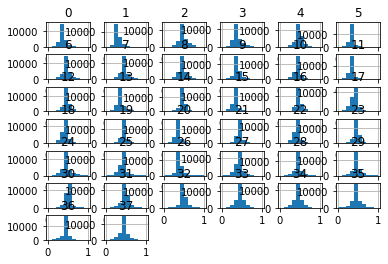

In [114]:
Xp.hist()

## Aprendizaje

In [116]:
lr = LogisticRegression()

In [117]:
lr.fit(Xp,yt)

LogisticRegression()

In [119]:
roc_auc_score(y_true=yt,y_score=lr.predict_proba(Xp)[:,1])

0.7969563186452537

In [121]:
roc_auc_score(y_true=yv,y_score=lr.predict_proba(pipe.transform(Xv[best]))[:,1])

0.7980611629134681

In [132]:
Xv[Xv.index==7330]

,acaso,agua,ano,camino,casa,castigo,causa,cielo,ciudad,conforme,...,tomar,tu,varon,venir,ver,vida,volver,vosotro,voz,yo
7330,0.708522,0.0,0.0,0.0,0.0,0.705688,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
pd.Series(lr.predict_proba(pipe.transform(Xv[best]))[:,0]).sort_values(ascending=False)

7330     0.999482
9561     0.998964
10911    0.998922
5630     0.998730
9747     0.998205
           ...   
7062     0.001623
8811     0.001389
8107     0.000791
4780     0.000784
7808     0.000618
Length: 11202, dtype: float64

## Persistencia de objetos

In [125]:
pickle.dump((STOP_WORDS,nlp,hapaxes,tfidf,var,pipe,best,lr),open('obj_bib_cor.pkl','wb'))

In [136]:
pd.set_option('display.max_columns',None)

In [137]:
Xv.assign(y=yv).corr()

,acaso,agua,ano,camino,casa,castigo,causa,cielo,ciudad,conforme,corazon,cosa,creer,dar,david,decir,dia,dio,dios,egipto,ejercito,el,entrar,enviar,espiritu,este,fuego,gente,hablar,hacer,hermano,hija,hijo,hijo israel,hombre,ir,israel,jehova,jehova dios,jerusalen,jesus,juda,levantar,ley,llamar,lugar,mano,mar,mensajero,mil,mio,moises,monte,morir,muerto,mujer,no,nombre,ny,obra,oh,oir,ojo,oro,padre,palabra,pasar,pecado,poder,poner,por,profeta,pueblo,puerta,pues,que,querer,responder,rey,saber,sacerdote,salir,santo,senor,ser,siervo,subir,tanto,tiempo,tierra,tomar,tu,varon,venir,ver,vida,volver,vosotro,voz,yo,y
acaso,1.000000,0.000114,-0.016059,-0.010620,-0.020097,0.022655,-0.007689,0.044461,-0.017893,-0.012704,0.000807,-0.010874,0.060963,0.003738,-0.017489,0.000492,-0.012349,0.056449,0.043381,-0.008427,-0.014154,0.019093,-0.009347,-0.000850,-0.003737,-0.001936,-0.013695,0.033643,-0.014863,0.007953,-0.011723,-0.008304,-0.029189,-0.013316,-0.020417,-0.009163,-0.020870,-0.042977,-0.016987,-0.015434,-0.015505,-0.016317,-0.014340,-0.013027,-0.009035,-0.003690,-0.009685,0.001139,0.020993,-0.012336,0.001125,-0.002534,-0.014047,-0.008178,0.000275,-0.017817,0.008134,-0.014616,-0.022525,0.003271,0.006571,-0.014225,-0.015876,-0.009747,-0.009990,-0.012644,-0.011382,-0.003230,0.013608,-0.014875,0.001520,-0.011895,-0.001480,-0.012003,-0.016402,0.010434,0.003927,0.015354,-0.024190,-0.008400,-0.016014,-0.016934,-0.010676,0.044553,-0.002390,-0.011579,-0.012593,-0.012155,-0.007975,0.003518,-0.006001,-0.008739,-0.010764,-0.022207,0.015443,-0.007626,-0.012025,-0.013336,-0.007168,-0.003891,-0.232343
agua,0.000114,1.000000,-0.017833,0.005718,-0.005346,-0.015070,0.005572,0.040266,-0.006756,-0.014108,-0.015540,-0.012459,-0.003278,0.006995,-0.003628,-0.019968,-0.012740,-0.014849,-0.033129,0.004662,-0.004875,-0.018505,-0.004449,0.016761,0.006949,-0.016091,-0.001486,-0.010000,-0.018599,-0.006519,-0.019829,-0.010226,-0.030288,0.001280,-0.006574,-0.013612,-0.016572,-0.008814,-0.018864,-0.008045,-0.009441,-0.013087,-0.011957,-0.009916,0.002603,-0.010177,-0.010282,0.049714,-0.009777,-0.013699,-0.007214,-0.007948,0.012619,0.001794,-0.002466,-0.004794,-0.013856,-0.003587,-0.000964,-0.017941,-0.008115,-0.000998,-0.000328,-0.013272,-0.016600,-0.020204,0.023294,-0.010783,-0.006717,0.022637,-0.004122,-0.012917,-0.016744,-0.002388,-0.003766,-0.011504,-0.000813,-0.006108,-0.022401,-0.006803,-0.006740,0.008235,-0.006070,-0.022230,-0.007997,-0.008634,0.012472,-0.013498,0.004186,0.029845,0.005056,-0.017529,-0.000266,0.013214,-0.006777,-0.005124,0.019903,-0.009846,-0.011243,-0.015063,0.026394
ano,-0.016059,-0.017833,1.000000,-0.012967,0.003162,-0.003057,-0.014804,-0.012188,-0.000088,0.017996,-0.015871,-0.017128,-0.017662,-0.011415,0.002541,-0.030638,0.023144,-0.026309,-0.036750,0.008294,-0.001942,-0.033633,-0.004527,-0.005044,-0.009863,-0.013929,-0.014642,-0.004612,-0.009742,-0.010392,-0.012178,0.045131,0.002000,0.007884,-0.020506,-0.014610,0.032159,-0.001338,-0.013000,0.053373,-0.018183,0.026527,-0.006171,-0.012441,-0.005228,-0.017146,-0.019339,-0.008992,-0.014336,0.011234,-0.009830,-0.002879,-0.016743,0.040446,-0.010765,-0.005255,-0.013772,0.004539,-0.016914,-0.016344,-0.017895,-0.013922,-0.017365,-0.011562,-0.015716,-0.007654,-0.009518,-0.008795,-0.006777,-0.017286,-0.015208,-0.008405,-0.021235,-0.014307,-0.011712,-0.017725,-0.010067,-0.019663,0.047133,-0.014290,-0.001104,0.005416,-0.015621,-0.021583,-0.014937,-0.009183,0.004997,-0.011099,0.002372,-0.004671,-0.001312,-0.022333,0.006462,-0.001729,-0.015562,-0.004619,-0.000593,-0.015701,-0.014956,-0.022464,0.046237
camino,-0.010620,0.005718,-0.012967,1.000000,-0.014216,-0.013019,0.006789,-0.014120,-0.010251,-0.006972,0.000463,-0.017041,-0.006314,-0.007886,-0.002111,-0.024245,0.001240,0.004033,-0.018426,-0.003306,0.001614,-0.010728,0.000431,-0.012824,-0.011610,-0.013180,-0.011953,-0.008103,-0.008562,-0.008646,-0.014203,-0.010392,-0.026331,-0.009184,0.001520,0.014416,-0.010482,0.004790,0.017432,-0.007186,-0.017449,-0.010061,-0.0